In [1]:
from torch.utils.data import DataLoader
from utils.visualisation import visualise_image, plot_band_distribution
from utils.data import create_dataloaders
import torch
import config

device = config.device
DATA_PATH = config.PATH_TO_DATA

%load_ext autoreload
%autoreload 2

### Illustrate Data Loaders

In [3]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, batch_size=4)

In [4]:
def illustrate_data_loader(loader, show_n_images: int):
    for i, (batch_sample, batch_masks) in enumerate(loader):
        image, label = batch_sample[0], batch_masks[0]
        label = label.unsqueeze(0)
        image, label = torch.permute(image, (1, 2, 0)), torch.permute(label, (1, 2, 0))
        visualise_image(image.numpy(), label.numpy())
        if i >= show_n_images:
            return
        
def speedtest_dataloader(size, same, num_workers=0, ):
    train_loader, _, _ = create_dataloaders(DATA_PATH, batch_size=size, batch_transforms=same, num_workers=num_workers)
    for x, y in train_loader: # iterate through one batch
        pass
    return

torch.Size([4, 3, 128, 128])
torch.Size([4, 1, 128, 128])
Visualsing 4 examples


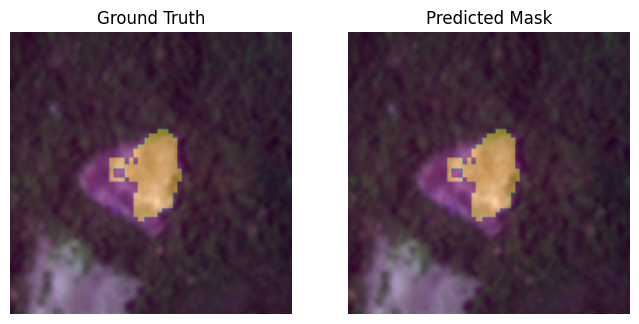

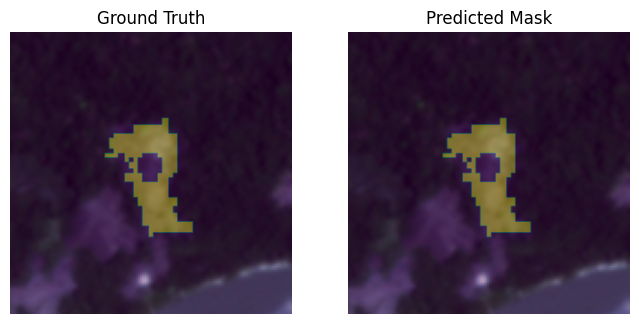

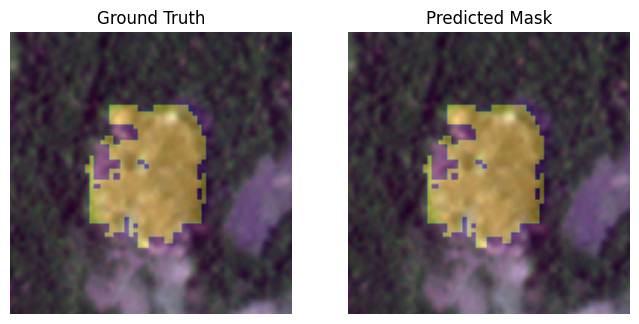

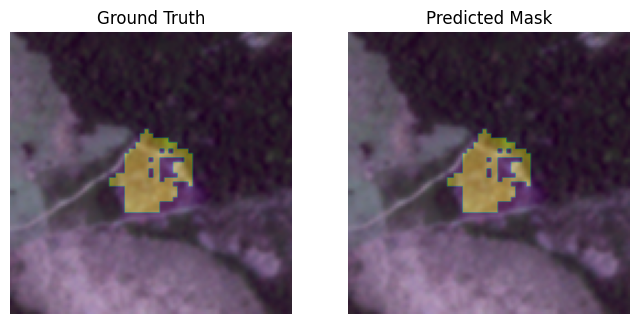

In [5]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, batch_size=4, bands=[0,1 , 2], transforms=False)

batch_sample, batch_masks = next(iter(train_loader))
batch_masks = batch_masks.unsqueeze(1)

from utils.evaluation import visualise_batch_predictions
print(batch_sample.shape)
print(batch_masks.shape)
visualise_batch_predictions(batch_sample, batch_masks, batch_masks, bands=[0, 1, 2], rescale=False)

IndexError: index 3 is out of bounds for axis 2 with size 3

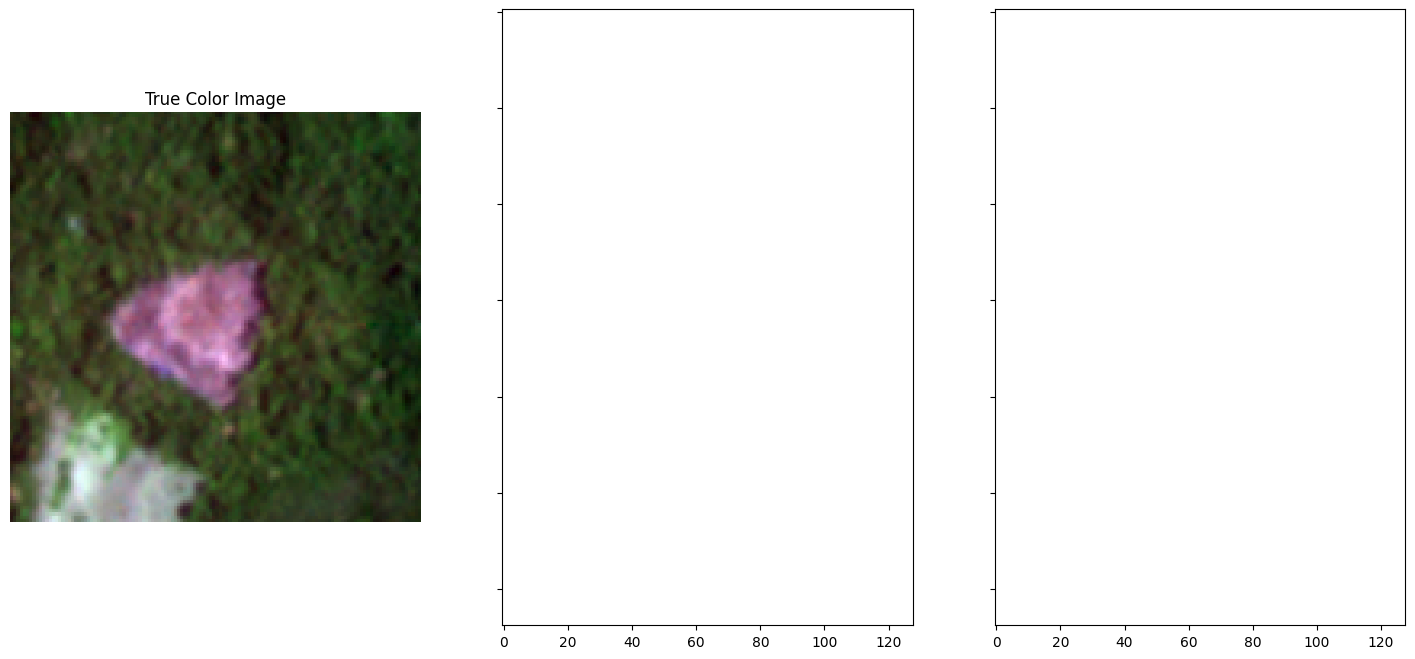

In [6]:
illustrate_data_loader(train_loader, 10)

IndexError: index 3 is out of bounds for axis 2 with size 3

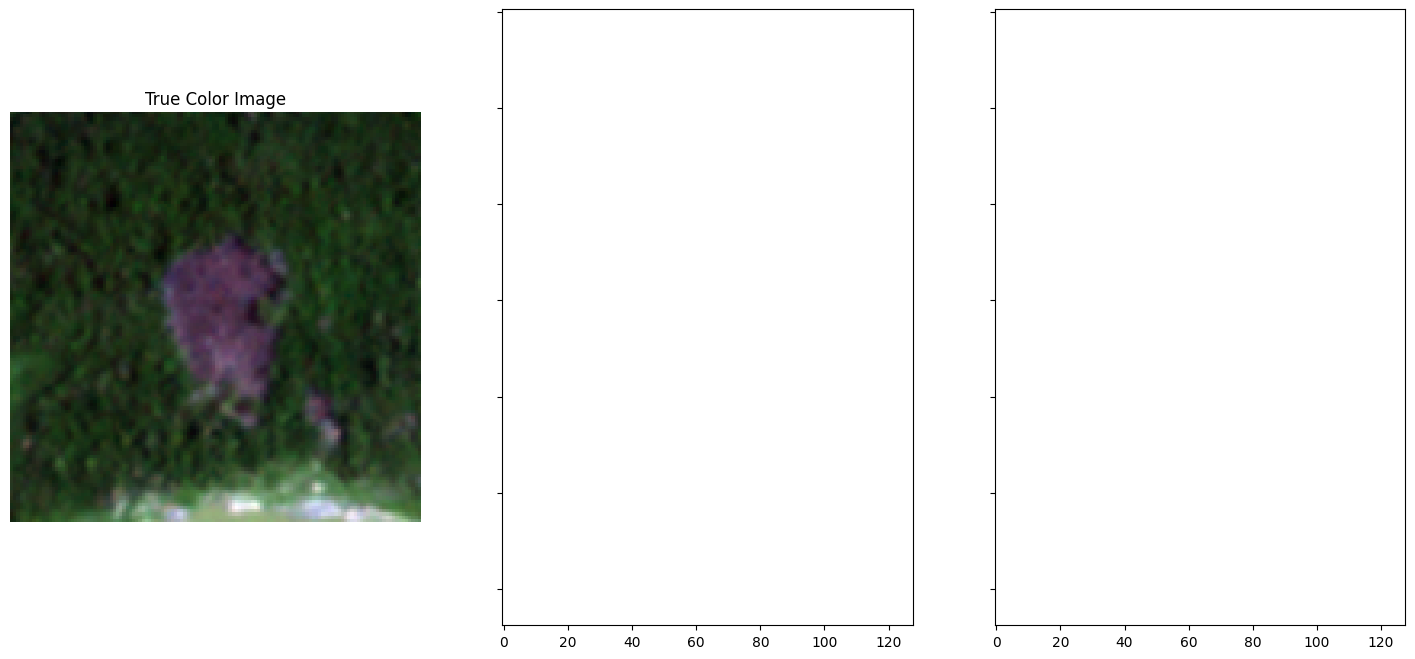

In [7]:
illustrate_data_loader(val_loader, 5)

In [ ]:
illustrate_data_loader(test_loader, 5)

#### Illustrate distribution of raw values across bands

In [ ]:
dataset = PlanetDataset(data_dir=DATA_PATH, bands=[0,1,2,3])
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0)
dataloader = iter(dataloader)

In [ ]:
sample, mask = next(dataloader)
for batch_num in range(4):
    plot_band_distribution(sample[batch_num,:,:,:])

In [ ]:
# pre-calculated means, std, mins, max of raw images calculated on the full test set:
means = torch.tensor([ 265.7371,  445.2234,  393.7881, 2773.2734])
stds = torch.tensor([ 91.8786, 110.0122, 191.7516, 709.2327])
mins = torch.tensor([ 0., 21.,  6., 77.])
max = torch.tensor([ 4433.,  5023.,  8230., 10000.])

"""
means = torch.mean(train_sample.float(), dim=(0, 1, 2))
std = torch.std(train_sample.float(), dim=(0, 1, 2))
min = torch.amin(train_sample.float(), dim=(0, 1, 2))
max = torch.amax(train_sample.float(), dim=(0, 1, 2))
"""

### MLE Predictions based on Mutlivariate Gauassian

In [2]:
train_loader, val_loader, test_loader = create_dataloaders(DATA_PATH, bands=[0, 1, 2, 3, 4], batch_size=2000, transforms=False) # get full train and val dataset

In [3]:
def prepare_data(X_in, y_in):
    X_out = torch.permute(X_in, (1, 0, 2, 3)).flatten(start_dim=1).T
    y_out = y_in.flatten(start_dim=0)

    assert X_out.shape[0] == len(y_out)
    print("Dimensions of transformed output: ")
    print("Data: {}".format(X_out.shape))
    print("Labels: {}".format(y_out.shape))
    return X_out, y_out

def pull_train_loader(loader, n_pulls):
    image_batches = []
    mask_batches = []
    for _ in range(n_pulls):
        batch_x, batch_y = next(iter(loader))
        image_batches.append(batch_x)
        mask_batches.append(batch_y)

    X = torch.cat(image_batches, 0)
    y = torch.cat(mask_batches, 0)
    return X, y

In [4]:
X_train, y_train = pull_train_loader(train_loader, 1)
X_test, y_test = next(iter(test_loader))
X_val, y_val = next(iter(val_loader))

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_test.shape)

X_train, y_train = prepare_data(X_train, y_train)
X_test, y_test = prepare_data(X_test, y_test)
X_val, y_val = prepare_data(X_val, y_val)

torch.Size([1030, 5, 128, 128])
torch.Size([283, 5, 128, 128])
torch.Size([299, 5, 128, 128])
torch.Size([283, 128, 128])
Dimensions of transformed output: 
Data: torch.Size([16875520, 5])
Labels: torch.Size([16875520])
Dimensions of transformed output: 
Data: torch.Size([4636672, 5])
Labels: torch.Size([4636672])
Dimensions of transformed output: 
Data: torch.Size([4898816, 5])
Labels: torch.Size([4898816])


In [5]:
import numpy as np

class MLE_model():
    def __init__(self, ):
        self.pos_means = None
        self.neg_means = None
        self.pos_cov = None
        self.neg_cov = None

    def fit(self, X_train, y_train):
        
        # seperate data into both classes
        pos = (y_train==1)
        neg = (y_train==0)

        X_train_pos = X_train[pos, :]
        X_train_neg = X_train[neg, :]

        # fit multivariate gaussian distributions for both classes
        self.pos_means = torch.mean(X_train_pos, dim=0).numpy()
        self.pos_cov = np.cov(X_train_pos.numpy().T)

        self.neg_means = torch.mean(X_train_neg, dim=0).numpy()
        self.neg_cov = np.cov(X_train_neg.numpy().T)

        # validate fitting process
        print("Model Fitted with means {} and {}".format(self.pos_means, self.neg_means))
        print("Covariance matrix are \n {} \n and \n {}".format(self.pos_cov, self.neg_cov))
        return

    def predict(self, X_test):

        # convert to numpy
        X_test = X_test.numpy()

        # Run MLE estimator
        # calculate log odds for both classes
        log_ps = [self.compute_log_p_solution(X_test, m, s) for m, s in zip([self.neg_means, self.pos_means], [self.neg_cov, self.pos_cov])]
        
        # take argmax
        assignments = np.argmax(log_ps, axis=0)
        return log_ps, assignments
    
    def compute_log_p_solution(self, X, mean, sigma):
        d = X.shape[1]
        c = -np.log(2 * np.pi) * (d / 2) - 0.5 * np.log(np.linalg.det(sigma))
        A = X - mean
        invSigma = np.linalg.inv(sigma)

        return -0.5 * np.sum(A * (A.dot(invSigma)), axis=1) + c


In [6]:
# train and predict
model = MLE_model()
model.fit(X_train, y_train)

log_ps, pred_tot = model.predict(X_test)

Model Fitted with means [3.2505014e+02 4.8271475e+02 5.3785321e+02 2.1697717e+03 7.1925169e-01] and [2.4483235e+02 4.3200955e+02 3.4301254e+02 2.9859758e+03 8.3960778e-01]
Covariance matrix are 
 [[ 5.81012935e+03  5.61265066e+03  9.21056247e+03 -3.64770807e+03
  -4.17726977e+00]
 [ 5.61265066e+03  8.02831044e+03  9.05270339e+03  2.50118718e+04
  -5.11665307e-01]
 [ 9.21056247e+03  9.05270339e+03  1.97930376e+04 -1.38821455e+04
  -7.29556022e+00]
 [-3.64770807e+03  2.50118718e+04 -1.38821455e+04  4.24431814e+05
   5.44940701e+01]
 [-4.17726977e+00 -5.11665307e-01 -7.29556022e+00  5.44940701e+01
   1.02479449e-02]] 
 and 
 [[ 7.69222322e+03  9.03224484e+03  1.46804847e+04 -1.18522200e+04
  -5.60131004e+00]
 [ 9.03224484e+03  1.28686680e+04  1.80996469e+04  2.85496626e+03
  -5.52047703e+00]
 [ 1.46804847e+04  1.80996469e+04  3.28585891e+04 -3.42848618e+04
  -1.16096916e+01]
 [-1.18522200e+04  2.85496626e+03 -3.42848618e+04  3.57097162e+05
   3.41335243e+01]
 [-5.60131004e+00 -5.52047703e

In [7]:
test_loss = 0
true_pos = 0
true_neg = 0
false_neg = 0
false_pos = 0

target = torch.tensor(y_test, dtype=torch.int64)
pred = torch.tensor(pred_tot, dtype=torch.int64)

true_pos += ((target == 1) & (pred == 1)).sum().item()
true_neg += ((target == 0) & (pred == 0)).sum().item()
false_neg += ((target == 1) & (pred == 0)).sum().item()
false_pos += ((target == 0) & (pred == 1)).sum().item()

# Calculate metrics (on GPU if needed)
accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)
precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
recall = true_pos / (true_pos + false_neg) if (true_pos + false_pos) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) else 0
jaccard = true_pos / (true_pos + false_neg + false_pos) if (true_pos + false_neg + false_pos) else 0

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

Accuracy: 0.8248
F1: 0.779
Jaccard: 0.638
Precision: 0.7389
Recall: 0.8238


C:\Users\lucas\AppData\Local\Temp\ipykernel_4244\3612497558.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y_test, dtype=torch.int64)


In [16]:
test = torch.tensor(log_ps)

In [18]:
test.argmax(1).dtype

torch.int64

In [8]:
_, _, test_loader = create_dataloaders(DATA_PATH, bands=[0, 1, 2, 3, 4], batch_size=8, transforms=False) # get full train and val dataset
loader = iter(test_loader)

torch.Size([8, 128, 128])
Visualsing 8 examples


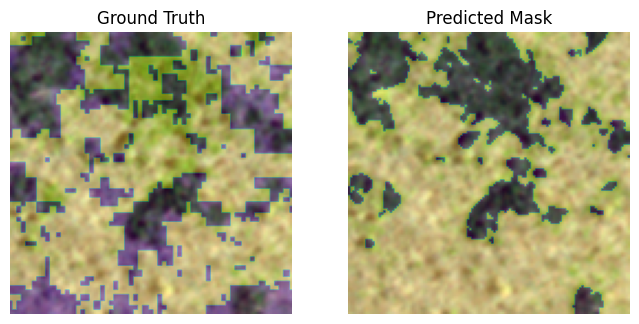

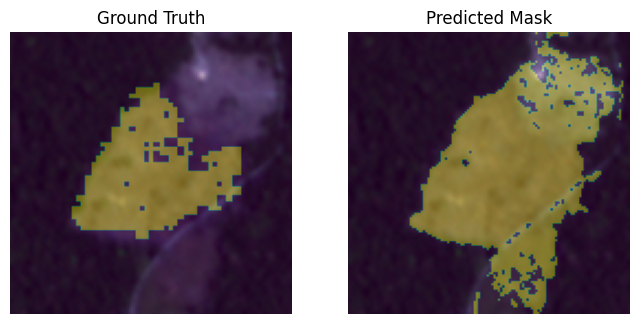

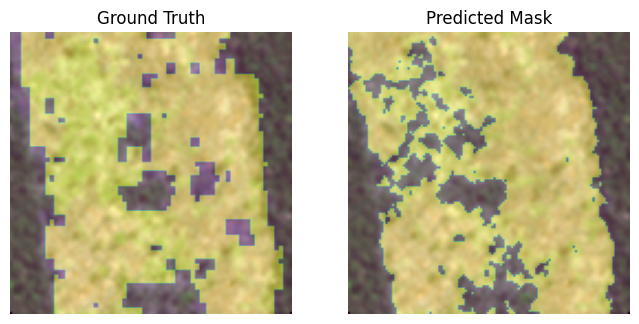

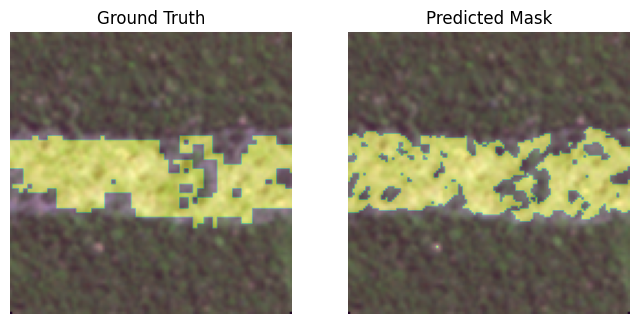

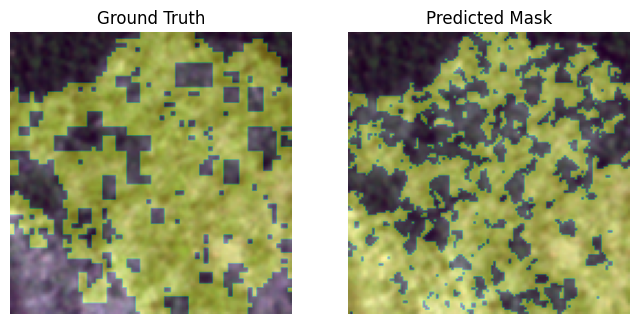

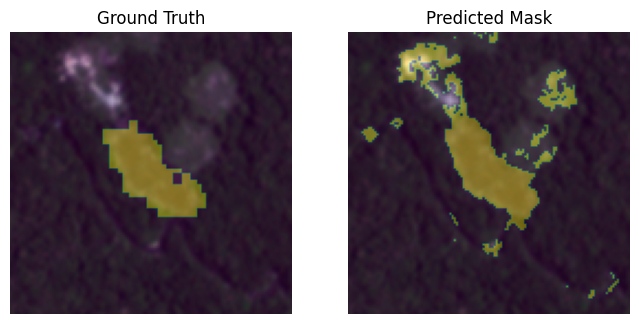

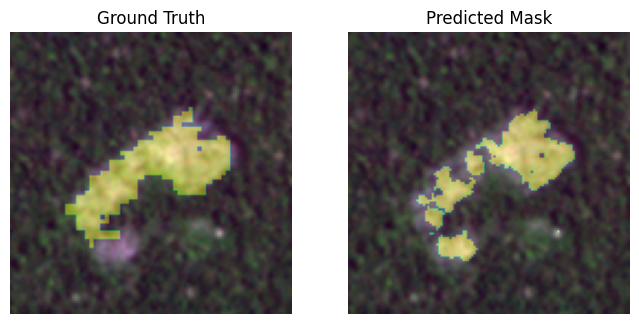

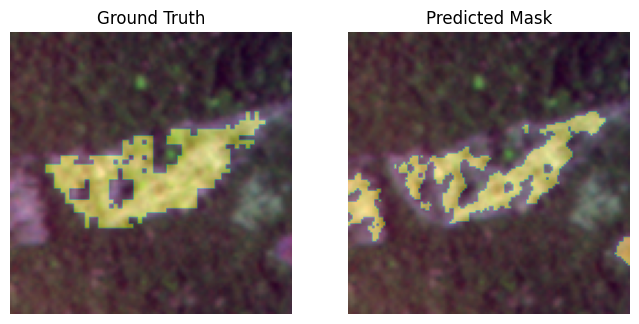

In [10]:
from utils.evaluation import visualise_batch_predictions
batch_sample, batch_mask = next(loader)
print(batch_mask.shape)
_, batch_output = model.predict(torch.permute(batch_sample, (1, 0, 2, 3)).flatten(start_dim=1).T)
batch_predictions = torch.tensor(batch_output).reshape(8, 1, 128, 128)
visualise_batch_predictions(batch_sample, batch_mask.unsqueeze(1), batch_predictions, rescale=True, bands=[0, 1, 2, 3, 4])

In [ ]:
from utils.data import normalized_image
import matplotlib.pyplot as plt
from torchvision import transforms

def show_overlay(image, mask, prediction):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 12))

    # reorder images to (H, W, C) and normalize image for better plotting
    image = torch.permute(image, (1, 2, 0)).cpu().numpy()
    image = normalized_image(image)
    mask = torch.permute(mask, (1, 2, 0)).cpu().numpy()
    prediction = torch.permute(prediction, (1, 2, 0)).cpu().numpy()

    # print mask and original
    axes[0].imshow(image)
    axes[0].imshow(mask, alpha=0.4,)
    axes[0].axis("off")
    axes[0].set_title("Ground Truth")

    # print prediction and original
    axes[1].imshow(image)
    axes[1].imshow(prediction, alpha=0.4,)
    axes[1].axis("off")
    axes[1].set_title("Predicted Mask")
    return

def visualise_batch_predictions(batch_image, batch_mask, batch_prediction, rescale=False, bands=[0, 1, 2]):
    batch_size = batch_image.shape[0]
    
    
    print("Visualsing {} examples".format(batch_size))

    # batch_prediction = batch_prediction.sigmoid() > 0.5 # take sigmoid and threshold at 0.5
    
    # constants to rescale image
    means = -1 * torch.tensor([265.7371, 445.2234, 393.7881, 2773.2734, 0.8082])
    stds = 1 / torch.tensor([91.8786, 110.0122, 191.7516, 709.2327, 1.0345e-01])
    temp1, temp2 = torch.tensor([0, 0, 0, 0, 0]), torch.tensor([1, 1, 1, 1, 1])

    means, stds =  means[bands], stds[bands]
    temp1, temp2 = temp1[bands], temp2[bands]

    for index in range(batch_size):
        
        # get image, mask and prediction at index
        image = batch_image[index, :, :, :]
        mask = batch_mask[index, :, :, :]
        prediction = batch_prediction[index, :, :, :]
        
        if rescale:
            invTrans = transforms.Compose([transforms.Normalize(mean = temp1,
                                                            std = stds),
                                        transforms.Normalize(mean = means,
                                                            std = temp2),
                                    ])
            image = invTrans(image)
        image = image[:3, :, :]
        show_overlay(image, mask, prediction)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([16, 3, 128, 128])
Visualsing 16 examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

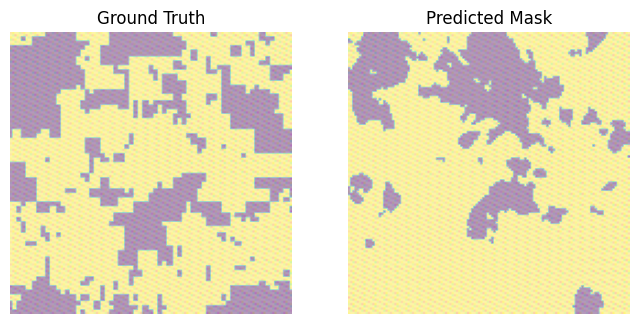

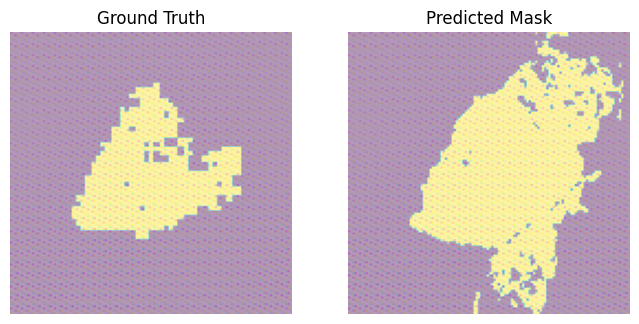

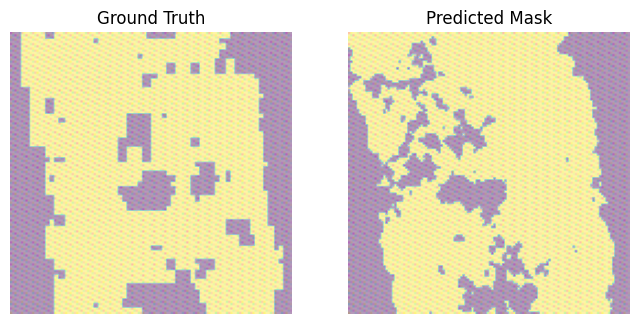

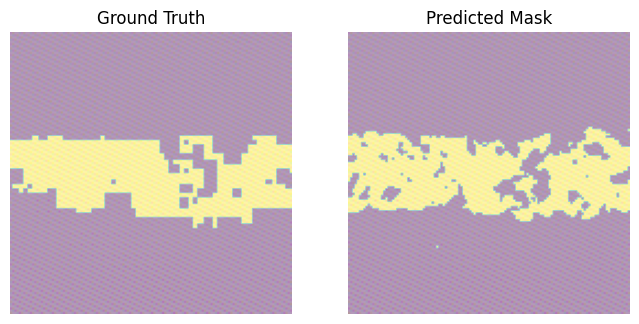

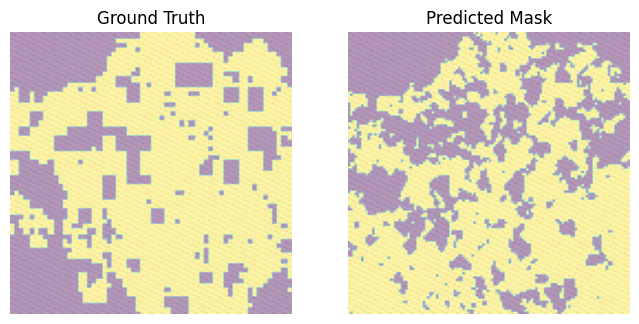

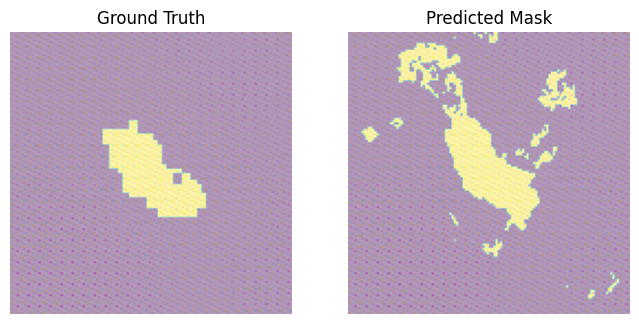

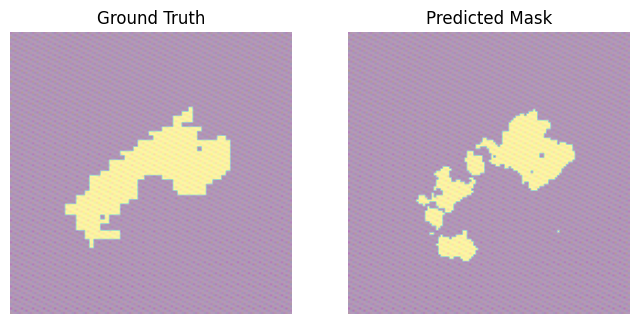

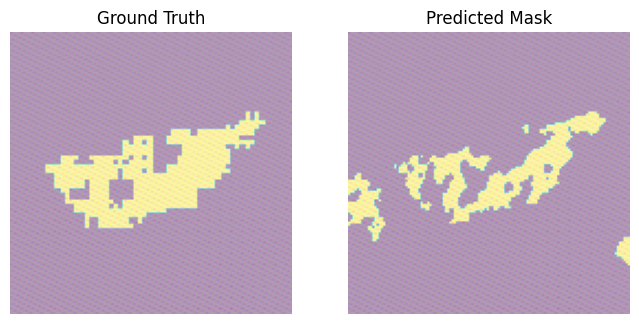

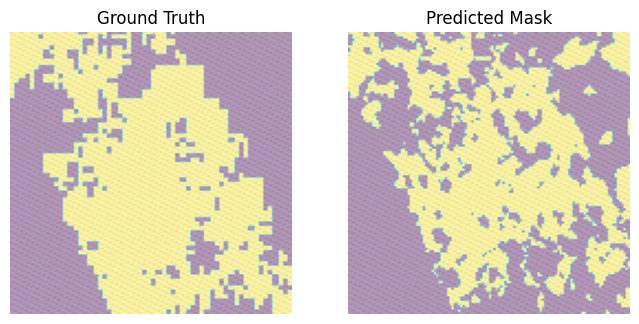

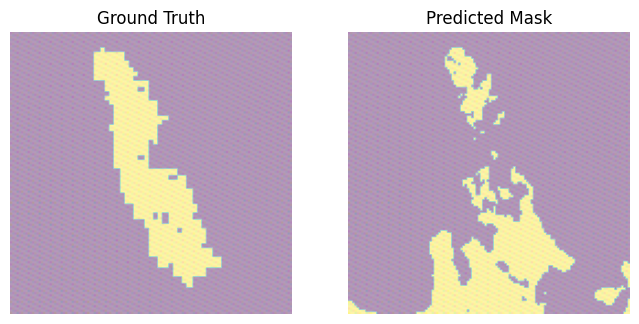

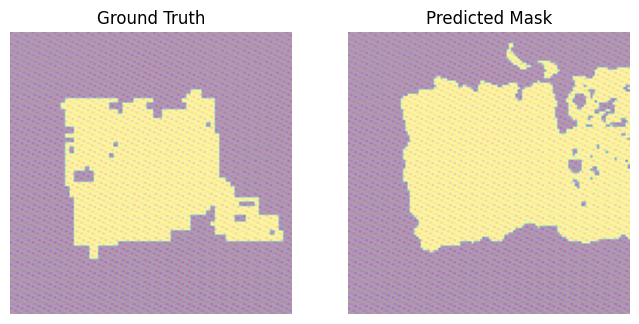

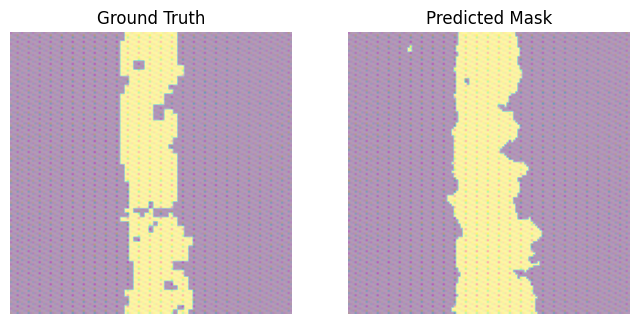

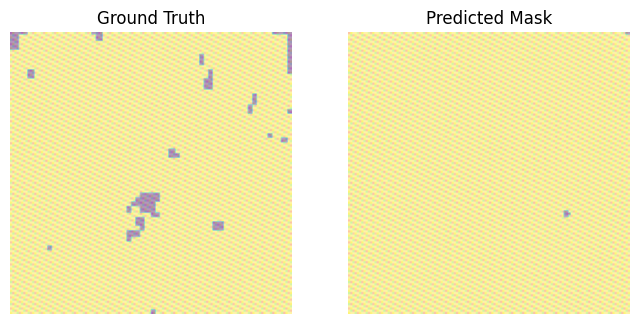

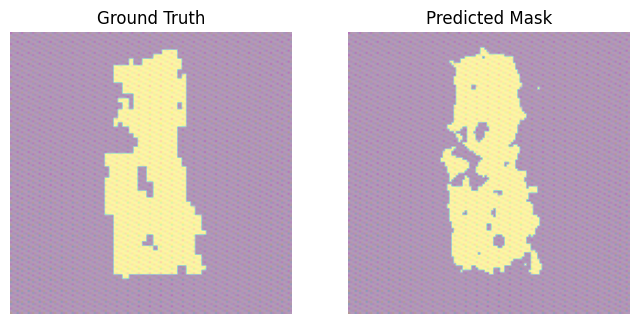

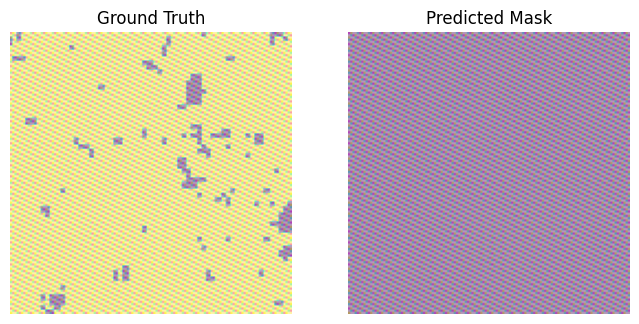

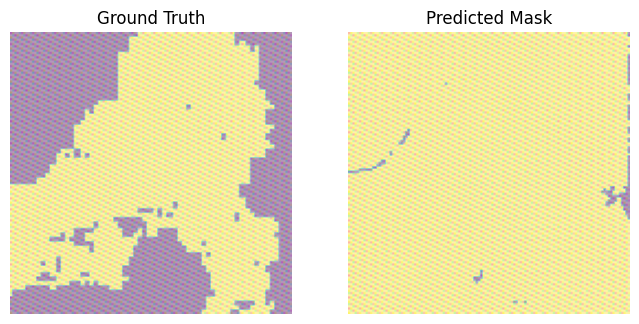

In [ ]:
# from utils.evaluation import visualise_batch_predictions
im_size = 128
batch_sample = torch.reshape(X_test, [283, 5, im_size, im_size])[:, [0, 1, 2,], :, :]
batch_predictions = torch.reshape(pred, (283, 1, im_size, im_size))
batch_mask = torch.reshape(target, (283, 1, im_size, im_size))

batch_sample, batch_predictions, batch_mask = batch_sample[8:24, :, :, :], batch_predictions[8:24, :, :, :], batch_mask[8:24, :, :, :]
print(batch_sample.shape)

visualise_batch_predictions(batch_sample, batch_mask, batch_predictions, rescale=False, bands=[0, 1, 2,])

In [ ]:
# evaluate on test set
from sklearn.metrics import accuracy_score, jaccard_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, pred_tot)   
jaccard = jaccard_score(y_test, pred_tot, average='binary') # equivalent to IOU
precision = precision_score(y_test, pred_tot, average='binary')
recall = recall_score(y_test, pred_tot, average='binary')
f1 = f1_score(y_test, pred_tot, average='binary') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

Accuracy: 0.8253
F1: 0.7799
Jaccard: 0.6392
Precision: 0.7388
Recall: 0.8257


In [ ]:
# evaluate on val set
log_ps, pred_tot = model.predict(X_val)

accuracy = accuracy_score(y_val, pred_tot)   
jaccard = jaccard_score(y_val, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_val, pred_tot, average='macro')
recall = recall_score(y_val, pred_tot, average='macro')
f1 = f1_score(y_val, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

Accuracy: 0.8415
F1: 0.8073
Jaccard: 0.6846
Precision: 0.7972
Recall: 0.8212


In [ ]:
# training performance
log_ps, pred_tot = model.predict(X_train)

accuracy = accuracy_score(y_train, pred_tot)   
jaccard = jaccard_score(y_train, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_train, pred_tot, average='macro')
recall = recall_score(y_train, pred_tot, average='macro')
f1 = f1_score(y_train, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

KeyboardInterrupt: 

## Testing unsupervised methods for good measure

In [ ]:
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components=2, verbose=True)

n_samples = 20_000_000
indices = np.random.choice(np.arange(n_samples), size=n_samples)

X_train_ = X_train[indices, :]

model.fit(X_train_)

print("Found means: ", model.means_)
print("Found covariances: ", model.covariances_)

Initialization 0


: 

In [ ]:
pred_tot = model.predict(X_test)

In [ ]:
print(print(pred_tot.mean()))

In [ ]:
# since this is unspervised, we need to flip the class (if accuracy on your machine is bad, just flip it back by rerunning this cell)
pred_tot = np.where(pred_tot==1, 0, 1)

In [ ]:
accuracy = accuracy_score(y_test, pred_tot)
jaccard = jaccard_score(y_test, pred_tot, average='macro') # equivalent to IOU
precision = precision_score(y_test, pred_tot, average='macro')
recall = recall_score(y_test, pred_tot, average='macro')
f1 = f1_score(y_test, pred_tot, average='macro') # equivalent to Dice index

print("Accuracy: {:.4}".format(accuracy))
print("F1: {:.4}".format(f1))
print("Jaccard: {:.4}".format(jaccard))
print("Precision: {:.4}".format(precision))
print("Recall: {:.4}".format(recall))

In [ ]:
# --> we outperform any existing paper and our own NN without even using labels
